## Install the package dependencies before running this notebook

In [424]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import pickle
from glob import glob
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [105]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [223]:
batch_size = 10  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_size, drop_last = True)

## Sample a batch of data and visualize 

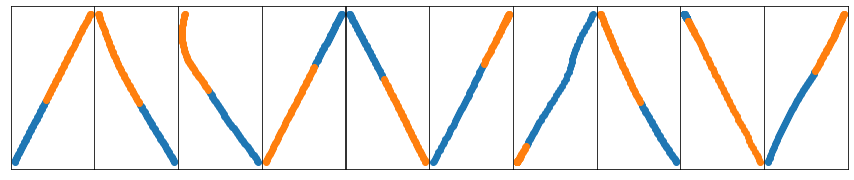

In [56]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    
    show_sample_batch(sample_batch)
    break

## Make Sequencial Data

In [281]:
X = []
Y = []
seq_len = 10
for x, y in train_dataset:
    t = np.concatenate([x,y])
    for j in range(len(t) - seq_len - 1):
        x = t[j : j+seq_len]
        y = t[j+1 : j+seq_len+1]
        X.append(x)
        Y.append(y)
train_data = list(zip(X,Y))

In [282]:
batch_size = 30  # batch size 
train_loader_ = DataLoader(train_data, batch_size=batch_size, drop_last = True)

In [178]:
class driver (nn.Module):
    
    def __init__(self, n_features, hidden_size, n_layers, lr):
        
        super().__init__()
        self.lr = lr
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.n_features = n_features
        self.output_size = n_features
        
        #layers
        self.lstm = nn.LSTM(self.n_features, self.hidden_size, self.n_layers, batch_first = True)
        self.FC = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = out.reshape(-1,self.hidden_size)
        out = self.FC(out)
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        weights = next(self.parameters()).data
        hidden = (weights.new(self.n_layers, batch_size, self.hidden_size).zero_(),
                  weights.new(self.n_layers, batch_size, self.hidden_size).zero_())
        return hidden

In [430]:
def customLoss(inp, out):
    x1,x2 = zip(*inp)
    y1,y2 = zip(*out)
    x1, x2, y1, y2 = torch.tensor(x1), torch.tensor(x2), torch.tensor(y1), torch.tensor(y2)
    return sum(np.sqrt(np.square(x1-y1) + np.square(x2-y2)))
    
def train(model,epochs,lr):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    lossF = customLoss
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        h = model.init_hidden(batch_size)
        for X, y in train_loader_:
            h = tuple([each.data for each in h])
            optimizer.zero_grad()
            output, h = model(X.float(), h)
            loss = lossF(output, torch.reshape(y, [300, 2]))
            loss = Variable(loss, requires_grad = True)
            epoch_loss += loss
            loss.backward()
            optimizer.step()
            
        print(f"Epoch: {epoch+1} Loss:{epoch_loss/len(train_loader_)}")
        
    return model
        

In [ ]:
n_hidden = 150
n_layers = 3
lr = 0.005
epochs = 30
n_features = 2


lauda = driver(2, n_hidden, n_layers, lr)
lauda = train(lauda, epochs, lr)